In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/SupervisedML/DrivingBehavior

Mounted at /gdrive
/gdrive/MyDrive/SupervisedML/DrivingBehavior


In [2]:
import pandas as pd
import numpy as np

from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2, l1
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import SGD

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.collections import LineCollection
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

np.random.seed = 47

# Data from: https://www.kaggle.com/datasets/shashwatwork/driving-behavior-dataset
data = pd.read_csv('features_14.csv', header=0)
data.head()

,Target,AccMeanX,AccMeanY,AccMeanZ,AccCovX,AccCovY,AccCovZ,AccSkewX,AccSkewY,AccSkewZ,...,GyroMaxZ,GyroVarX,GyroVarY,GyroVarZ,GyroMedianX,GyroMedianY,GyroMedianZ,GyroStdX,GyroStdY,GyroStdZ
0,1,0.285339,-0.138611,-0.957764,0.022150,0.003975,0.001926,0.867594,-1.305868,-0.507254,...,0.832061,0.761120,0.184372,0.262859,-0.286260,4.251908,0.706107,0.872422,0.429385,0.512697
1,1,0.313477,-0.161670,-0.956250,0.020571,0.005640,0.001456,0.002474,-0.395088,-0.677572,...,0.832061,3.061080,0.585991,0.270340,0.335878,3.969466,0.587786,1.749594,0.765501,0.519942
2,1,0.325195,-0.158325,-0.950155,0.017281,0.004579,0.001388,-0.354212,-0.603657,-0.984635,...,0.832061,3.137076,0.552431,0.905518,-0.286260,3.832061,0.240458,1.771179,0.743257,0.951587
3,1,0.336565,-0.172468,-0.937640,0.015305,0.005216,0.002253,-0.655653,-0.152454,-0.040530,...,0.832061,2.809524,3.963056,0.893127,0.335878,3.969466,-0.106870,1.676163,1.990743,0.945054
4,1,0.337860,-0.164185,-0.941681,0.013132,0.005020,0.002062,-0.718488,-0.446061,0.250539,...,0.832061,2.667567,3.414394,0.799787,-0.286260,4.038168,-0.179389,1.633269,1.847808,0.894308


In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

# plot
ax = sns.countplot(x="Target", hue="Target", data=data)
ax.set(ylabel='Bar Count', title='Bar Count and Percent of Total')

# add annotations
for c in ax.containers:
    
    # custom label calculates percent and add an empty string so 0 value bars don't have a number
    labels = [f'{h/data.Target.count()*100:0.1f}%' if (h := v.get_height()) > 0 else '' for v in c]
    
    ax.bar_label(c, labels=labels, label_type='edge')

plt.show()


SyntaxError: ignored

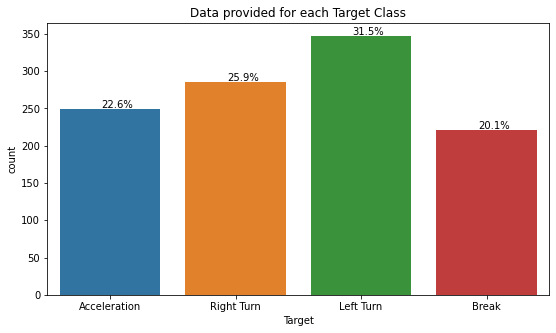

In [62]:
plt.figure(figsize=(9,5))

total = float(len(data))

ax = sns.countplot(x="Target", data=data)
plt.title('Data provided for each Target Class', fontsize=12)
ax.set_xticklabels(['Acceleration','Right Turn','Left Turn','Break'])

for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width()/1.75
    y = p.get_height() +2
    ax.annotate(percentage, (x, y), ha='center')

plt.show()

In [ ]:
data.shape

(1102, 61)

In [ ]:
null_df = data.isnull().sum()
null_df

Target         0
AccMeanX       0
AccMeanY       0
AccMeanZ       0
AccCovX        0
              ..
GyroMedianY    0
GyroMedianZ    0
GyroStdX       0
GyroStdY       0
GyroStdZ       0
Length: 61, dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1102 entries, 0 to 1101
Data columns (total 61 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Target       1102 non-null   int64  
 1   AccMeanX     1102 non-null   float64
 2   AccMeanY     1102 non-null   float64
 3   AccMeanZ     1102 non-null   float64
 4   AccCovX      1102 non-null   float64
 5   AccCovY      1102 non-null   float64
 6   AccCovZ      1102 non-null   float64
 7   AccSkewX     1102 non-null   float64
 8   AccSkewY     1102 non-null   float64
 9   AccSkewZ     1102 non-null   float64
 10  AccKurtX     1102 non-null   float64
 11  AccKurtY     1102 non-null   float64
 12  AccKurtZ     1102 non-null   float64
 13  AccSumX      1102 non-null   float64
 14  AccSumY      1102 non-null   float64
 15  AccSumZ      1102 non-null   float64
 16  AccMinX      1102 non-null   float64
 17  AccMinY      1102 non-null   float64
 18  AccMinZ      1102 non-null   float64
 19  AccMax

Text(0.5, 1.0, 'Correlation Heatmap')

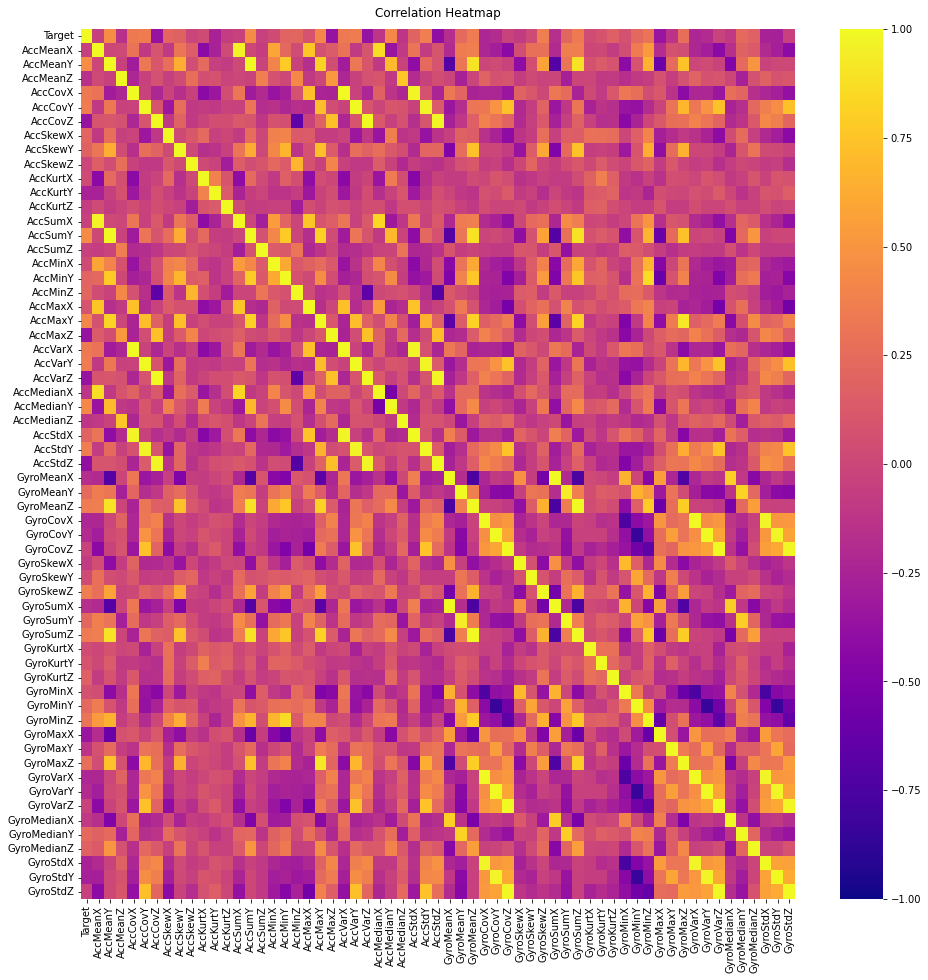

In [ ]:
import seaborn as sns

# Increase the size of the heatmap.
plt.figure(figsize=(16, 16))

heatmap = sns.heatmap(data.corr(), cmap="plasma", vmin=-1, vmax=1, annot=False)

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

In [3]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
data['Target'] = le.fit_transform(data['Target'])

In [ ]:
data

,Target,AccMeanX,AccMeanY,AccMeanZ,AccCovX,AccCovY,AccCovZ,AccSkewX,AccSkewY,AccSkewZ,...,GyroMaxZ,GyroVarX,GyroVarY,GyroVarZ,GyroMedianX,GyroMedianY,GyroMedianZ,GyroStdX,GyroStdY,GyroStdZ
0,0,0.285339,-0.138611,-0.957764,0.022150,0.003975,0.001926,0.867594,-1.305868,-0.507254,...,0.832061,0.761120,0.184372,0.262859,-0.286260,4.251908,0.706107,0.872422,0.429385,0.512697
1,0,0.313477,-0.161670,-0.956250,0.020571,0.005640,0.001456,0.002474,-0.395088,-0.677572,...,0.832061,3.061080,0.585991,0.270340,0.335878,3.969466,0.587786,1.749594,0.765501,0.519942
2,0,0.325195,-0.158325,-0.950155,0.017281,0.004579,0.001388,-0.354212,-0.603657,-0.984635,...,0.832061,3.137076,0.552431,0.905518,-0.286260,3.832061,0.240458,1.771179,0.743257,0.951587
3,0,0.336565,-0.172468,-0.937640,0.015305,0.005216,0.002253,-0.655653,-0.152454,-0.040530,...,0.832061,2.809524,3.963056,0.893127,0.335878,3.969466,-0.106870,1.676163,1.990743,0.945054
4,0,0.337860,-0.164185,-0.941681,0.013132,0.005020,0.002062,-0.718488,-0.446061,0.250539,...,0.832061,2.667567,3.414394,0.799787,-0.286260,4.038168,-0.179389,1.633269,1.847808,0.894308
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1097,3,0.273228,-0.094552,-0.983939,0.055210,0.034427,0.002588,0.458098,-0.614773,0.529063,...,8.893130,2.129663,1.720142,4.873553,-0.500000,4.526718,1.083969,1.459337,1.311542,2.207612
1098,3,0.264683,-0.092791,-0.976266,0.050594,0.033875,0.001917,0.479824,-0.640988,1.008758,...,8.893130,2.051938,1.389759,4.557117,-0.500000,4.526718,1.083969,1.432459,1.178880,2.134740
1099,3,0.257098,-0.091030,-0.976039,0.047140,0.033445,0.001903,0.532820,-0.673323,1.009590,...,8.893130,2.006199,1.378221,4.568735,-0.500000,4.522901,1.083969,1.416403,1.173977,2.137460
1100,3,0.257132,-0.091047,-0.978446,0.047143,0.033445,0.002054,0.532226,-0.672990,0.987714,...,8.893130,2.041545,1.448443,4.603264,-0.500000,4.538168,1.083969,1.428826,1.203513,2.145522


In [71]:
from sklearn.model_selection import train_test_split

X = data.drop(['Target'], axis = 1)
y = data['Target']

from sklearn.preprocessing import StandardScaler, MinMaxScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=5)

sc = MinMaxScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
y_test

731     2
763     2
11      0
869     2
366     1
       ..
1052    3
258     1
627     2
591     2
938     3
Name: Target, Length: 221, dtype: int64

In [72]:
from sklearn import metrics
from sklearn.ensemble import ExtraTreesClassifier

model = ExtraTreesClassifier()
model.fit(X, y)

# display the relative importance of each attribute
print(model.feature_importances_)

[0.0115468  0.02485603 0.00453993 0.02810141 0.03065923 0.00763133
 0.00406418 0.02303142 0.00258753 0.00427657 0.00539953 0.001487
 0.01076678 0.02766285 0.00218833 0.02501445 0.04083706 0.0050363
 0.01901476 0.05722357 0.00707557 0.03432915 0.03309525 0.00821749
 0.01122724 0.01402161 0.00330054 0.02747996 0.03391255 0.00901443
 0.0093272  0.00427107 0.05551602 0.00397477 0.0074555  0.0376011
 0.0012756  0.00134803 0.01215038 0.00538321 0.00520411 0.03912094
 0.0020575  0.00140524 0.0039986  0.00707726 0.01078369 0.05512593
 0.0100365  0.00590762 0.06881835 0.0049723  0.00752984 0.04496732
 0.00424332 0.00365245 0.00221367 0.0048637  0.00516542 0.05695454]


In [73]:
print(f"{'Feature': <25}{'Importance Score': >1}")
print('-'*40)

for i in range(0,11):
  print(f'{X.columns.to_list()[i] : <25} {round(model.feature_importances_[i],4): >5}')

Feature                  Importance Score
----------------------------------------
AccMeanX                  0.0115
AccMeanY                  0.0249
AccMeanZ                  0.0045
AccCovX                   0.0281
AccCovY                   0.0307
AccCovZ                   0.0076
AccSkewX                  0.0041
AccSkewY                  0.023
AccSkewZ                  0.0026
AccKurtX                  0.0043
AccKurtY                  0.0054


In [107]:
from tabulate import tabulate

a = X.columns.to_list()
b = model.feature_importances_

c = pd.DataFrame(a)
c['Importance Score'] = b
c.rename(columns={0:'Features'}, inplace=True)
c = c.sort_values(by=['Importance Score'], ascending=False)
tab_df = c[:10]

print(tabulate(tab_df, headers='keys', tablefmt='psql'))

+----+------------+--------------------+
|    | Features   |   Importance Score |
|----+------------+--------------------|
| 50 | GyroMaxZ   |          0.0688184 |
| 19 | AccMaxY    |          0.0572236 |
| 59 | GyroStdZ   |          0.0569545 |
| 32 | GyroMeanZ  |          0.055516  |
| 47 | GyroMinZ   |          0.0551259 |
| 53 | GyroVarZ   |          0.0449673 |
| 16 | AccMinY    |          0.0408371 |
| 41 | GyroSumZ   |          0.0391209 |
| 35 | GyroCovZ   |          0.0376011 |
| 21 | AccVarX    |          0.0343291 |
+----+------------+--------------------+


In [75]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score


# fit model no training data
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

print(xgb_model)

XGBClassifier(objective='multi:softprob')


In [77]:
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix

# make predictions for test data
y_pred = xgb_model.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
print(classification_report(y_test, y_pred))

Accuracy: 99.55%
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        45
           1       1.00      1.00      1.00        58
           2       1.00      1.00      1.00        71
           3       1.00      0.98      0.99        47

    accuracy                           1.00       221
   macro avg       0.99      0.99      0.99       221
weighted avg       1.00      1.00      1.00       221



In [ ]:
!pip install --upgrade xgboost

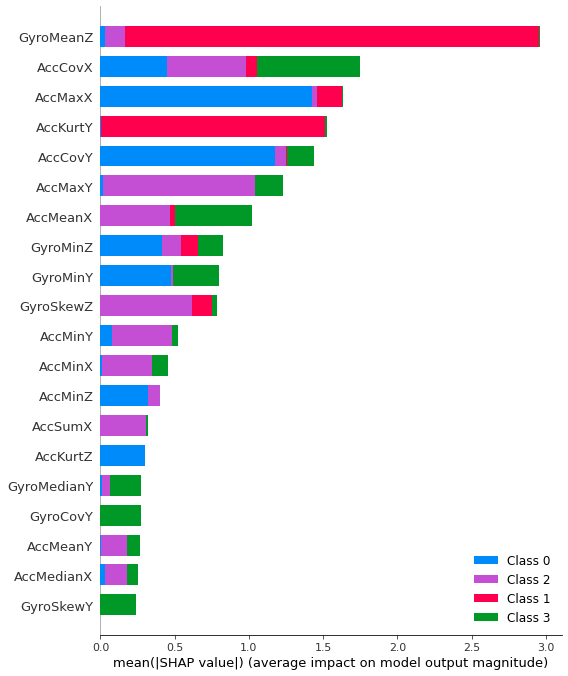

In [78]:
import shap

# this takes a minute or two since we are explaining over 30 thousand samples in a model with over a thousand trees

explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X)

shap.summary_plot(shap_values, X)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix

dct = DecisionTreeClassifier()
dct.fit(X_train,y_train)
y_pred_dct = dct.predict(X_test)
print(f"The accuracy score for Decision Tree is {(accuracy_score(y_test,y_pred_dct)*100).round(2)} %")

The accuracy score for Decision Tree is 99.1 %


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=1000)
rf.fit(X_train,y_train)
y_pred_rf = rf.predict(X_test)
print(f"The accuracy score for Random Forest is {(accuracy_score(y_test,y_pred_rf)*100).round(2)}")

The accuracy score for Random Forest is 100.0


In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn import tree
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

fn=data.feature_names
cn=data.target_names
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=800)
tree.plot_tree(rf.estimators_[0],
               feature_names = fn, 
               class_names=cn,
               filled = True);
fig.savefig('rf_individualtree.png')

In [5]:
# Implement your code here
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.regularizers import l2, l1
from tensorflow.keras.optimizers import SGD

# Stochastic Logistic Regression
model = Sequential()

model.add(Dense(units=128, input_shape=[X_train.shape[1]], activation='relu', kernel_regularizer=l2(0.001)))
model.add(Dense(units=64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(units=32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(units=4, activation='sigmoid'))

# Compile model
sgd = SGD(learning_rate=0.01)
model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               7808      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 4)                 132       
                                                                 
Total params: 18,276
Trainable params: 18,276
Non-trainable params: 0
_________________________________________________________________


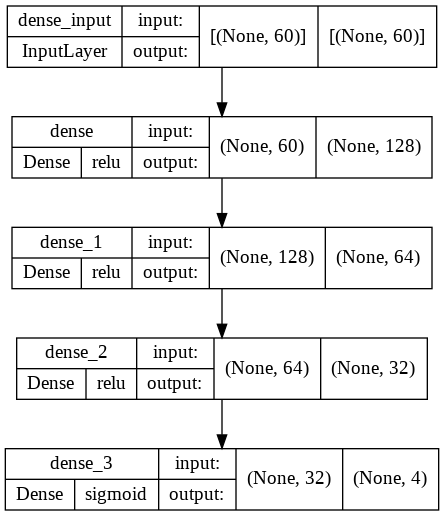

In [7]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png'
, show_shapes=True, 
           show_layer_names=True, rankdir='TB'
, show_layer_activations=True)

In [ ]:
# Fit the model
history = model.fit(
    X_train, 
    y_train, 
    batch_size = 256,
    epochs = 100, 
    verbose=1, 
    validation_data=(X_test, y_test),
)

Epoch 1/100
4/4 [==============================] - 2s 91ms/step - loss: 2.7186 - accuracy: 0.4257 - val_loss: 2.5499 - val_accuracy: 0.7059
Epoch 2/100
4/4 [==============================] - 0s 16ms/step - loss: 2.5078 - accuracy: 0.6856 - val_loss: 2.3645 - val_accuracy: 0.7873
Epoch 3/100
4/4 [==============================] - 0s 15ms/step - loss: 2.3314 - accuracy: 0.7741 - val_loss: 2.1952 - val_accuracy: 0.8597
Epoch 4/100
4/4 [==============================] - 0s 15ms/step - loss: 2.1662 - accuracy: 0.8422 - val_loss: 2.0328 - val_accuracy: 0.9005
Epoch 5/100
4/4 [==============================] - 0s 17ms/step - loss: 2.0065 - accuracy: 0.8808 - val_loss: 1.8720 - val_accuracy: 0.9276
Epoch 6/100
4/4 [==============================] - 0s 15ms/step - loss: 1.8520 - accuracy: 0.9069 - val_loss: 1.7166 - val_accuracy: 0.9231
Epoch 7/100
4/4 [==============================] - 0s 14ms/step - loss: 1.7079 - accuracy: 0.9012 - val_loss: 1.5857 - val_accuracy: 0.9367
Epoch 8/100
4/4 [===

In [ ]:
# Get the predictions
y_pred=model.predict(x=X_test)

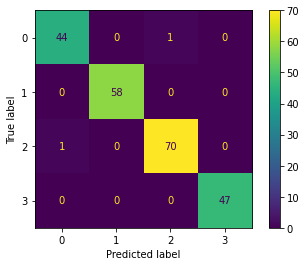

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)


disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

plt.rcParams['figure.figsize'] = [20, 10]
plt.show()